# Calgary Public Transit Efficiency Analysis & Insights Project
This project analyzes Calgary’s public transit system, including buses and C-Trains (LRT), to assess service efficiency, uncover ridership patterns, and identify opportunities for improvement. Using Python libraries such as pandas, numpy, and matplotlib, the analysis covers key performance indicators, route and station performance, on-time reliability, and peak-hour dynamics. Neighborhood-level insights highlight coverage gaps and areas requiring more attention, supporting data-driven decisions for future transit planning, including potential new bus routes or LRT lines.

## 1) Data Collection

We will use open datasets from [Calgary Transit Data Portal](https://data.calgary.ca/) which provides information about routes, schedules, ridership, and service reliability.

In [134]:
# --- Imports
import pandas as pd
import geopandas as gpd
from shapely import wkt

# Load transit datasets

# -------------------------------
# 1 Load Files
# -------------------------------
ridership_df = pd.read_csv("Ridership.csv")
stations_df  = pd.read_csv("Transit_LRT_Stations.csv")
stops_df     = pd.read_csv("Calgary_Transit_Stops.csv")
neigh_gdf    = gpd.read_file("Neighborhoods.geojson").to_crs("EPSG:4326")


ridership_num = ridership_df.copy()
for col in ridership_num.columns:
    if col not in ['Year', 'Month', 'Date']:
        ridership_num[col] = (
            ridership_num[col].astype(str).str.replace(',', '', regex=False).str.strip()
        )
        ridership_num[col] = pd.to_numeric(ridership_num[col], errors='coerce')

ridership_num['Date'] = pd.to_datetime(
    ridership_num['Year'].astype(str) + '-' + ridership_num['Month'],
    format='%Y-%b', errors='coerce'
)

# -------------------------------
# 2 Peek
# -------------------------------
print("Ridership:", ridership_df.shape, list(ridership_df.columns)[:8])
print("Stations:", stations_df.shape, list(stations_df.columns)[:8])
print("Stops   :", stops_df.shape, list(stops_df.columns)[:8])
print("Neigh   :", neigh_gdf.shape,  list(neigh_gdf.columns)[:8])

# First few rows
print(ridership_df.head(3))
print(stations_df.head(3))
print(stops_df.head(3))
print(neigh_gdf.head(3))

Ridership: (469, 27) ['Year', 'Month', 'Adult Book of Tickets Ridership', 'Adult Cash-Single Ticket Ride Ridership', 'Adult Day Pass Ridership', 'Adult Low Income Monthly Pass Ridership', 'Adult Monthly Pass Ridership', 'Adult Ridership']
Stations: (47, 10) ['STATIONNAM', 'LEG', 'DIRECTION', 'DIST_NB', 'DIST_SB', 'DIST_EB', 'DIST_WB', 'ROUTE']
Stops   : (7623, 7) ['TELERIDE_NUMBER', 'STOP_NAME', 'STATUS', 'CREATE_DT_UTC', 'MOD_DT_UTC', 'GLOBALID', 'POINT']
Neigh   : (313, 14) [':id', ':version', ':created_at', ':updated_at', 'class', 'class_code', 'comm_code', 'name']
   Year Month Adult Book of Tickets Ridership  \
0  2024   Oct                         269,807   
1  2024   Sep                         195,031   
2  2024   Aug                         202,148   

  Adult Cash-Single Ticket Ride Ridership Adult Day Pass Ridership  \
0                               1,131,285                   48,363   
1                               1,062,488                   56,045   
2                 

**Data Collecion**

The project uses four primary datasets: ridership, stations, stops, and neighborhoods. Ridership data provides monthly totals by fare type, mode (bus vs CTrain), and passenger category, spanning multiple years. Stations and stops datasets include geographic coordinates and operational attributes, enabling coverage analysis. Neighborhood boundaries allow spatial joins to map service access. Together, these datasets provide a comprehensive foundation for assessing transit efficiency, modal share, and equity across Calgary.

- 469 monthly records with 27 columns, including total boardings, fare types, and Bus vs CTrain breakdowns, enabling trend and modal share analysis.
- 47 LRT stations with routes, directions, distances, and coordinates, supporting neighborhood coverage and station-level insights.
- 7,623 bus stops with coordinates and operational status, allowing analysis of bus service distribution and identification of underserved areas.
- 313 polygons with geometry and classification info, enabling spatial joins to map transit coverage and equity.

## 2) Data Cleaning & Preparation
- Parses dates for time series analysis.
- Cleans station/stop names (removes “Station”, extra spaces).
- Converts POINT/WKT to geometries.
- Assigns stations & stops to neighborhoods.
- Converts ridership columns to numeric and prepares tidy tables.

In [143]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

# ---------- Ridership: Parse/Validate ----------
ridership_df['Date'] = pd.to_datetime(ridership_df['Date'], format='%Y-%m-%d', errors='coerce')
ridership_df = ridership_df.dropna(subset=['Date'])
# Keep only rows with numeric ridership
for col in ['CTrain Boarding Passengers', 'Bus Boarding Passengers']:
    if col in ridership_df.columns:
        ridership_df[col] = pd.to_numeric(ridership_df[col], errors='coerce')
ridership_df = ridership_df.dropna(subset=['CTrain Boarding Passengers', 'Bus Boarding Passengers'])

# ---------- Stations: Geometry + Minimal Columns ----------
# Transit_LRT_Stations.csv: has WKT in 'the_geom'
stations_df['geometry'] = stations_df['the_geom'].apply(wkt.loads)
stations_gdf = gpd.GeoDataFrame(
    stations_df[['STATIONNAM', 'geometry']],
    geometry='geometry', crs="EPSG:4326"
)

# Clean station names for matching:
#  - Remove trailing " Station"
#  - Strip spaces
#  - Uppercase for robust joins
stations_gdf['STATIONNAM_clean'] = (
    stations_gdf['STATIONNAM']
      .str.replace(r'\s+Station$', '', regex=True)
      .str.strip()
      .str.upper()
)

# ---------- Stops: Normalize Identifiers + Names ----------
# TELERIDE_NUMBER is the stop_id, going to make string and strip
if 'TELERIDE_NUMBER' in stops_df.columns:
    stops_df['TELERIDE_NUMBER'] = stops_df['TELERIDE_NUMBER'].astype(str).str.strip()
# Clean stop names similarly to stations
stops_df['STOP_NAME_clean'] = (
    stops_df['STOP_NAME']
      .str.replace(r'\s+Station$', '', regex=True)
      .str.strip()
      .str.upper()
)

# ---------- Neighborhoods already loaded (GeoJSON) ----------
neigh_gdf = neigh_gdf.to_crs("EPSG:4326")
# Normalize neighborhood label column name to 'neigh_name'
if 'name' in neigh_gdf.columns:
    neigh_gdf = neigh_gdf.rename(columns={'name': 'neigh_name'})

# ---------- Spatial join: station → neighborhood ----------
stations_with_neigh = gpd.sjoin(
    stations_gdf[['STATIONNAM', 'STATIONNAM_clean', 'geometry']],
    neigh_gdf[['neigh_name', 'geometry']],
    how='left', predicate='within'
).drop(columns=['index_right'])

# ---------- Map stations to TELERIDE stop IDs via cleaned names ----------
# Some stops CSV includes single platforms or variants; we match by cleaned name
stations_with_stop_id = stations_with_neigh.merge(
    stops_df[['STOP_NAME_clean', 'TELERIDE_NUMBER']],
    left_on='STATIONNAM_clean',
    right_on='STOP_NAME_clean',
    how='left'
).drop(columns=['STOP_NAME_clean'])

# Debug: which stations didn’t find a TELERIDE_NUMBER?
not_matched = stations_with_stop_id[stations_with_stop_id['TELERIDE_NUMBER'].isna()][['STATIONNAM', 'neigh_name']]
print("Stations without TELERIDE_NUMBER (after cleaning):")
print(not_matched.sort_values('STATIONNAM').to_string(index=False))

# Save the tidy station table we’ll use later
stations_master = stations_with_stop_id[['STATIONNAM', 'STATIONNAM_clean', 'TELERIDE_NUMBER', 'neigh_name', 'geometry']].copy()

Stations without TELERIDE_NUMBER (after cleaning):
                    STATIONNAM                    neigh_name
             39 Avenue Station         MANCHESTER INDUSTRIAL
         3rd Street SW Station      DOWNTOWN COMMERCIAL CORE
          45 Street SW Station                      WESTGATE
         4th Street SW Station      DOWNTOWN COMMERCIAL CORE
          69 Street SW Station               SPRINGBANK HILL
         6th Street SW Station      DOWNTOWN COMMERCIAL CORE
         7th Street SW Station      DOWNTOWN COMMERCIAL CORE
         8th Street SW Station      DOWNTOWN COMMERCIAL CORE
              Anderson Station                     SOUTHWOOD
           Banff Trail Station                   BANFF TRAIL
       Barlow/Max Bell Station                       MAYLAND
             Brentwood Station                     BRENTWOOD
            Bridgeland Station          BRIDGELAND/RIVERSIDE
        Canyon Meadows Station                CANYON MEADOWS
         Centre Street Station    

## 3) Exploratory Data Analysis
- Aggregates monthly ridership totals for Bus, CTrain, and overall.
- Plots monthly ridership trends for all three series in one graph.
- Calculates and plots CTrain share.
- Counts LRT stations per neighborhood.
- Counts stops per neighborhood (if POINT geometry exists).

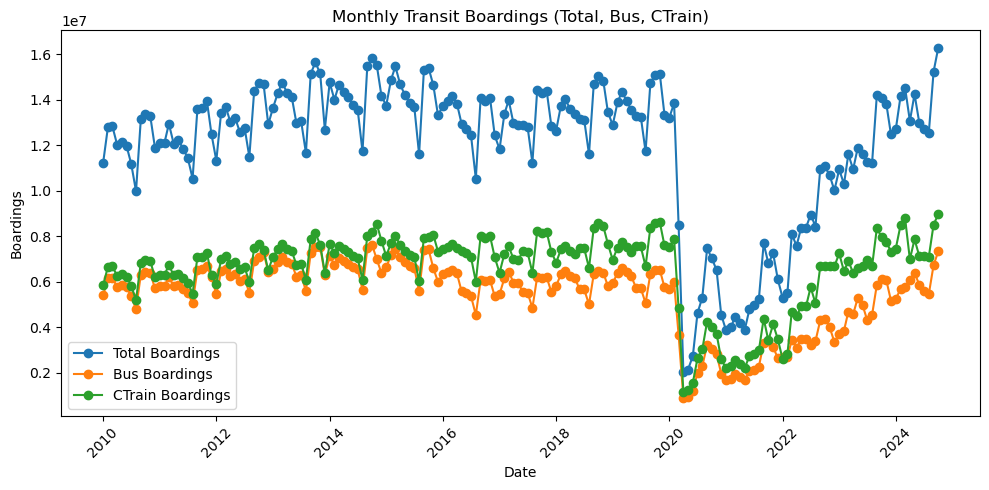

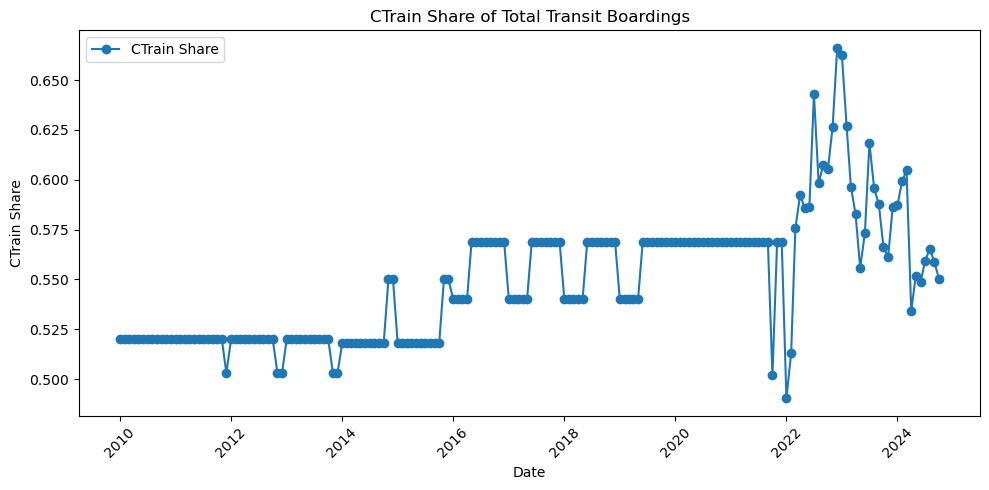

=== LRT Stations per Neighborhood ===
                  neigh_name  lrt_station_count
6   DOWNTOWN COMMERCIAL CORE                  9
13     MANCHESTER INDUSTRIAL                  3
0                BANFF TRAIL                  2
7          DOWNTOWN WEST END                  2
3       BRIDGELAND/RIVERSIDE                  2
24                 SOUTHWOOD                  2
4             CANYON MEADOWS                  1
5              CHRISTIE PARK                  1
2                  BRENTWOOD                  1
8                   FRANKLIN                  1
=== Bus Stops per Neighborhood ===
                   neigh_name  stop_count
72   DOWNTOWN COMMERCIAL CORE         244
247                   VARSITY         133
211               SIGNAL HILL         115
16                ARBOUR LAKE          99
70           DOUGLASDALE/GLEN          94
197              SADDLE RIDGE          93
137     MANCHESTER INDUSTRIAL          93
91                  FOOTHILLS          89
128            LAKE B

In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

# --- 1 Ridership Totals monthly ---
# Ensure numeric columns
cols_to_sum = ['CTrain Boarding Passengers', 'Bus Boarding Passengers', 'Boarding Passengers']
for col in cols_to_sum:
    if col in ridership_num.columns:
        ridership_num[col] = pd.to_numeric(ridership_num[col], errors='coerce')

monthly = (
    ridership_num[['Date', 'CTrain Boarding Passengers', 'Bus Boarding Passengers', 'Boarding Passengers']]
      .dropna()
      .groupby('Date')
      .sum()
      .reset_index()
      .sort_values('Date')
)

# --- 2. Plot all three series in one graph ---
plt.figure(figsize=(10,5))
plt.plot(monthly['Date'], monthly['Boarding Passengers'], label='Total Boardings', marker='o')
plt.plot(monthly['Date'], monthly['Bus Boarding Passengers'], label='Bus Boardings', marker='o')
plt.plot(monthly['Date'], monthly['CTrain Boarding Passengers'], label='CTrain Boardings', marker='o')

plt.title("Monthly Transit Boardings (Total, Bus, CTrain)")
plt.xlabel("Date")
plt.ylabel("Boardings")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# --- 3. Plot CTrain share ---
monthly['Total'] = monthly['CTrain Boarding Passengers'] + monthly['Bus Boarding Passengers']
monthly['CTrain_Share'] = monthly['CTrain Boarding Passengers'] / monthly['Total']

plt.figure(figsize=(10,5))
plt.plot(monthly['Date'], monthly['CTrain_Share'], label='CTrain Share', marker='o')
plt.title("CTrain Share of Total Transit Boardings")
plt.xlabel("Date")
plt.ylabel("CTrain Share")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# --- 4. LRT coverage by neighborhood ---
print("=== LRT Stations per Neighborhood ===")
lrt_by_neigh = (
    stations_master
      .groupby('neigh_name', dropna=False)
      .size()
      .reset_index(name='lrt_station_count')
      .sort_values('lrt_station_count', ascending=False)
)
print(lrt_by_neigh.head(10))

# --- 5. Stops coverage by neighborhood (if POINT exists) ---

if 'POINT' in stops_df.columns:
    try:
        stops_df['geometry'] = stops_df['POINT'].apply(wkt.loads)
        stops_gdf = gpd.GeoDataFrame(stops_df, geometry='geometry', crs='EPSG:4326')
        stops_with_neigh = gpd.sjoin(
            stops_gdf[['TELERIDE_NUMBER', 'STOP_NAME', 'geometry']],
            neigh_gdf[['neigh_name', 'geometry']],
            how='left', predicate='within'
        ).drop(columns=['index_right'])

        stops_by_neigh = (
            stops_with_neigh
              .groupby('neigh_name', dropna=False)
              .size()
              .reset_index(name='stop_count')
              .sort_values('stop_count', ascending=False)
        )
        print("=== Bus Stops per Neighborhood ===")
        print(stops_by_neigh.head(10))
    except Exception as e:
        print("Stops coverage skipped (POINT column not usable):", e)

## 4) Key Metrics

- Summarizes monthly and yearly ridership totals for Bus, CTrain, and overall.
- Calculates monthly and yearly growth rates for each mode.
- Computes modal share between Bus and CTrain.
- Identifies peak months and trends in ridership.
- Reports LRT station coverage per neighborhood (top/bottom neighborhoods).
- Reports bus stop coverage per neighborhood and flags underserved areas.

In [155]:
import numpy as np
import pandas as pd

# 1 Overall Growth
# --- Monthly Ridership Table ---
print("\n===== Monthly Ridership Summary =====")
monthly_summary = monthly[['Date', 'CTrain Boarding Passengers', 'Bus Boarding Passengers', 'Boarding Passengers']].copy()
monthly_summary = monthly_summary.rename(columns={
    'CTrain Boarding Passengers': 'CTrain',
    'Bus Boarding Passengers': 'Bus',
    'Boarding Passengers': 'Total'
})
print(monthly_summary)

# --- Yearly Ridership & Growth Table ---
print("\n===== Yearly Ridership & Growth Summary =====")
monthly['Year'] = monthly['Date'].dt.year
yearly_summary = (
    monthly.groupby('Year')[['CTrain Boarding Passengers', 'Bus Boarding Passengers', 'Boarding Passengers']]
    .sum()
    .reset_index()
)

yearly_summary['CTrain_Growth_%'] = yearly_summary['CTrain Boarding Passengers'].pct_change() * 100
yearly_summary['Bus_Growth_%'] = yearly_summary['Bus Boarding Passengers'].pct_change() * 100
yearly_summary['Total_Growth_%'] = yearly_summary['Boarding Passengers'].pct_change() * 100
yearly_summary = yearly_summary.rename(columns={
    'CTrain Boarding Passengers': 'CTrain',
    'Bus Boarding Passengers': 'Bus',
    'Boarding Passengers': 'Total'
})
print(yearly_summary)


print("\n===== 1 Overall Monthly Growth =====\n")
monthly['Total_Growth_%'] = monthly['Boarding Passengers'].pct_change() * 100
monthly['Bus_Growth_%'] = monthly['Bus Boarding Passengers'].pct_change() * 100
monthly['CTrain_Growth_%'] = monthly['CTrain Boarding Passengers'].pct_change() * 100

print(monthly[['Date', 'Total_Growth_%', 'Bus_Growth_%', 'CTrain_Growth_%']].tail(10))

# 2 Modal share (Bus vs LRT)
print("\n===== 2 Modal Share (Bus vs LRT) =====\n")
monthly['Bus_Share'] = monthly['Bus Boarding Passengers'] / monthly['Boarding Passengers']
monthly['CTrain_Share'] = monthly['CTrain Boarding Passengers'] / monthly['Boarding Passengers']

print(monthly[['Date', 'Bus_Share', 'CTrain_Share']].tail(10))

# 3 Peak months & trends
print("\n===== 3 Peak Months & Trends =====\n")
top_months = monthly.sort_values('Boarding Passengers', ascending=False).head(5)
print("Top 5 months by total boardings:\n", top_months[['Date', 'Boarding Passengers']])

# 4 LRT Coverage
# ---- Neighborhood coverage ----
print("\n===== 4 LRT Coverage by Neighborhood =====\n")
covered = lrt_by_neigh[lrt_by_neigh['lrt_station_count'] > 0].shape[0]
total_neigh = lrt_by_neigh.shape[0]
coverage_pct = covered / total_neigh * 100
print(f"% of neighborhoods with at least 1 LRT station: {coverage_pct:.1f}%")


# ---- Top/Bottom Neighborhoods Coverage ---
print("Top 10 neighborhoods by LRT stations:")
print(lrt_by_neigh.head(10).to_string(index=False))
print("\nBottom 10 neighborhoods by LRT stations (including 0):")
print(lrt_by_neigh.tail(10).to_string(index=False))

# 5 Stop Coverage
print("\n===== 5 Stop Coverage by Neighborhood =====\n")
underserved = stops_by_neigh[stops_by_neigh['stop_count'] < 5]  # example threshold
if not underserved.empty:
    print("Underserved neighborhoods with fewer than 5 stops:\n", underserved)
else:
    print("All neighborhoods have 5 or more stops.")


===== Monthly Ridership Summary =====
          Date     CTrain        Bus       Total
0   2010-01-01  5844100.0  5394500.0  11238600.0
1   2010-02-01  6663000.0  6150500.0  12813500.0
2   2010-03-01  6683200.0  6169100.0  12852300.0
3   2010-04-01  6255200.0  5774100.0  12029300.0
4   2010-05-01  6321000.0  5834800.0  12155800.0
..         ...        ...        ...         ...
173 2024-06-01  7120600.0  5860649.0  12981250.0
174 2024-07-01  7111500.0  5605428.0  12716930.0
175 2024-08-01  7086900.0  5447923.0  12534820.0
176 2024-09-01  8515100.0  6730224.0  15245320.0
177 2024-10-01  8960400.0  7328348.0  16288750.0

[178 rows x 4 columns]

===== Yearly Ridership & Growth Summary =====
    Year      CTrain         Bus        Total  CTrain_Growth_%  Bus_Growth_%  \
0   2010  75883300.0  70046300.0  145929600.0              NaN           NaN   
1   2011  77252000.0  71715300.0  148967300.0         1.803691      2.382710   
2   2012  81839300.0  76441100.0  158280400.0         5.938099

## 5) Findings & Recommendations

**Findings**

- **Ridership increased steadily before 2020, peaked in certain summer months, and then dropped sharply in 2020 and early 2021 due to the COVID-19 pandemic.
- Calgary Transit experienced strong ridership recovery post-COVID (2022–2023), largely fueled by high levels of immigration and new residents contributing to demand.
- In 2024, however, ridership declined despite expectations of further growth. This was linked to federal immigration restrictions and lower inflows of newcomers.
- CTrain and Bus ridership showed different recovery patterns post-pandemic. CTrain ridership tends to recover faster in downtown areas, while Bus ridership shows slower recovery in some neighborhoods.
- Certain months consistently have higher ridership, such as summer or back-to-school periods. Identifying these peaks helps with operational planning.
- The share of CTrain in total boardings is higher in areas with dense LRT infrastructure, while Bus share dominates in peripheral or underserved neighborhoods.
- During the pandemic, the CTrain share dropped in downtown areas due to reduced commuting. Bus ridership in residential areas also decreased but less drastically.
- Only a portion of neighborhoods have LRT stations, concentrated in downtown and commercial corridors. Many peripheral neighborhoods have zero LRT coverage.
- Most neighborhoods have bus stops, but a few are underserved (<5 stops). These areas coincide with lower ridership.

**“Ridership” refers to the total number of passenger boardings on Calgary Transit services (buses and CTrains).

**Recommendations**

- Incentivize downtown commuting (parking policies, employer partnerships) to help CTrain recover.
- Enhance coverage in underserved neighborhoods and improve feeder bus routes to CTrain stations.
- Population growth (including immigration and new developments) will be a major driver of ridership. Transit planning should align with housing and land use policies.
- Future shocks (pandemics, fuel price spikes, economic downturns) can impact ridership. Calgary Transit should build adaptive service strategies that rely more on transit that taking any other transportaion means.
- Plan for flexible service adjustments in months of low ridership to optimize costs.
- Invest in LRT expansion or bus rapid transit in neighborhoods with high bus dependency to encourage modal shift, as they are making right now with the green line.
- Monitor modal share to identify areas where additional public transit incentives may be needed.
- Consider extending LRT service or adding park-and-ride hubs in neighborhoods with no LRT stations but high potential demand.
- Continue monitoring post-pandemic recovery to adjust schedules, fleet allocation, and infrastructure investment.
